# Convergence tests for Cahn-Hilliard solvers: Part 1

This notebook explores spatial convergence while temporal convergence is explored based on manufactured solutions in another notebook.

In [1]:
import voxelsss as vox
import numpy as np
from numpy import sin, cos, pi
import torch
import matplotlib.pyplot as plt

### Define generic convergence test

We use the discrete $L_2$–norm of the difference divided by the $L_2$–norm of the exact solution, i.e. a relative $L_2$ error to quantify convergence.

In [2]:
def run_convergence_test(
    solver_call,        # a callable(vf, fieldname)->solver
    test_function,      # some function which return a torch tensor (shape [x,y,z])
    init_fun,           # exact init_fun(x,y,z)->np.ndarray
    exact_fun,          # exact_fun(x,y,z)->np.ndarray
    convention = 'cell_center',
    dtype = np.float32,
    powers = np.array([3,4,5,6,7])
):
    dx     = np.zeros(len(powers))
    errors = np.zeros(len(powers))

    for i, p in enumerate(powers):
        if convention == 'cell_center':
            vf = vox.VoxelFields(2**p, 2**p, 2**p, (1,1,1), convention=convention)
        elif convention == 'staggered_x':
            vf = vox.VoxelFields(2**p+1, 2**p, 2**p, (1,1,1), convention=convention)
        vf.precision = dtype
        vf.add_grid()
        init_data = init_fun(*vf.grid)
        vf.add_field("c", init_data)

        # Compute solutions
        solver = solver_call(vf, "c", device='cpu')
        comp = test_function(solver).squeeze(0).cpu().numpy()
        exact = exact_fun(*vf.grid)
        if convention == 'staggered_x':
            exact = exact[1:-1,:,:]

        # Error norm
        diff = comp - exact
        errors[i] = np.linalg.norm(diff)/np.linalg.norm(exact)
        dx[i]     = vf.spacing[0]

    return dx, errors

### Test 1: Laplacian stencil on periodic field

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.30522615 0.08629802 0.02225653 0.00560767 0.00140491]
Convergence rate from slope fit: 1.9470372045369948


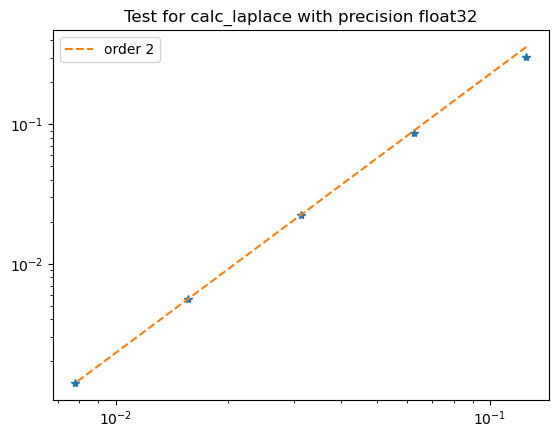

In [3]:
def init_fun(x,y,z):  
    return sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z) * ( 2**2 + 4**2 + 6**2)**(-1) *pi**(-2)

def laplace_init_fun(x,y,z):
    return -sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z)

precision = np.float32
dx, errors = run_convergence_test(
                    solver_call    = lambda vf, f, device='cpu': 
                                        vox.PeriodicCahnHilliardSolver(vf,f,device=device),
                    test_function  = lambda s: s.calc_laplace(s.apply_periodic_BC_cell_center(s.field))[:,1:-1,1:-1,1:-1],
                    init_fun       = init_fun,
                    exact_fun      = laplace_init_fun,
                    convention     = 'cell_center',
                    dtype          = precision
                )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
# Take last error as reference value
err_const = errors[-1]/dx[-1]**2 
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors, '*')
plt.loglog(dx, err_const*dx**2, '--', label='order 2')
plt.legend()
plt.title(f'Test for calc_laplace with precision {precision.__name__}')
plt.show()


### Test 2: Compute div( c*(1-c)*grad(mu) ) with predefined mu

Start out with a range of test functions to check for specific behaviour (will be shortly discussed below)

In [4]:
alpha = 0.4
beta = 0.1

def init_fun_c(x,y,z):
    if sol_type_2 == 1:
        fun =  0.5 +0.0*(x+y+z)
    if sol_type_2 == 2:
        fun =  x*(1-x)*x*(1-x)
    if sol_type_2 == 3:
        fun =  alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z)
    if sol_type_2 == 4:
        fun = alpha + beta*sin(2*pi*x)
    if sol_type_2 == 5:
        fun =  x*(1-x)
    if sol_type_2 == 6:
        fun =  alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z)
    return fun

def init_fun_mu(x,y,z):
    if sol_type_2 == 1:
        fun =  sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z)  
    if sol_type_2 == 2:    
         fun =  sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z) 
    if sol_type_2 == 3:
        fun = sin(2*pi*x)
    if sol_type_2 == 4:
        fun = 24.0*pi**2*beta*sin(2*pi*x) + (6.0*alpha + 6.0*beta*sin(2*pi*x))*(-2*alpha - 2*beta*sin(2*pi*x) + 1)*(-alpha - beta*sin(2*pi*x) + 1)
    if sol_type_2 == 5:    
         fun =  sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z)  
    if sol_type_2 == 6:
        fun =  x**2*(1 - x)**2
    return fun

def result_fun(x,y,z):
    if sol_type_2 == 1:
        fun =  -0.25* sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z)  *  ( 2**2 + 2**2 + 2**2) *pi**(2)
    if sol_type_2 == 2:    
         fun =  4*pi*x*(x - 1)*(-x**2*(x - 1)**2*(2*x - 1)*cos(2*pi*x) + 3*pi*x*(x - 1)*(x**2*(x - 1)**2 - 1)*sin(2*pi*x) - x*(x**2*(x - 1)**2 - 1)*cos(2*pi*x) - (x - 1)*(x**2*(x - 1)**2 - 1)*cos(2*pi*x))*sin(2*pi*y)*sin(2*pi*z)
    if sol_type_2 == 3:
        fun = 4*pi**2*(-beta*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z))*sin(2*pi*y)*sin(2*pi*z)*cos(2*pi*x)**2 - beta*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z) - 1)*sin(2*pi*y)*sin(2*pi*z)*cos(2*pi*x)**2 + (alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z))*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z) - 1)*sin(2*pi*x))
    if sol_type_2 == 4:
        fun = pi**2*beta*(-2*beta*(alpha + beta*sin(2*pi*x))*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 - 2*beta*(alpha + beta*sin(2*pi*x) - 1)*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 + (alpha + beta*sin(2*pi*x))*(alpha + beta*sin(2*pi*x) - 1)*(144.0*alpha**2*sin(2*pi*x) - 576.0*alpha*beta*(1 - cos(2*pi*x))**2 - 1152.0*alpha*beta*cos(2*pi*x) + 864.0*alpha*beta - 144.0*alpha*sin(2*pi*x) - 432.0*beta**2*(1 - cos(2*pi*x))**2*sin(2*pi*x) + 576.0*beta**2*sin(2*pi*x) - 432.0*beta**2*sin(4*pi*x) + 288.0*beta*(1 - cos(2*pi*x))**2 + 576.0*beta*cos(2*pi*x) - 432.0*beta + 24.0*sin(2*pi*x) + 96.0*pi**2*sin(2*pi*x)))
    if sol_type_2 == 5:   
        fun =  2*pi*(-x*(x - 1)*(2*x - 1)*cos(2*pi*x) + 6*pi*x*(x - 1)*(x*(x - 1) + 1)*sin(2*pi*x) - x*(x*(x - 1) + 1)*cos(2*pi*x) - (x - 1)*(x*(x - 1) + 1)*cos(2*pi*x))*sin(2*pi*y)*sin(2*pi*z)
    if sol_type_2 == 6:
        fun  = -4*pi*beta*x*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z))*(x - 1)*(2*x - 1)*sin(2*pi*y)*sin(2*pi*z)*cos(2*pi*x) - 4*pi*beta*x*(x - 1)*(2*x - 1)*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z) - 1)*sin(2*pi*y)*sin(2*pi*z)*cos(2*pi*x) - 2*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z))*(alpha + beta*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z) - 1)*(x**2 + 4*x*(x - 1) + (x - 1)**2)   
    return fun

Functions 5 and 6 are periodic in the initial concentration field, but the first / second derivative feature discontinuities at x=0 and x=1 which results in loss of the 2nd order convergence for those cases.

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors:       [0.05035877 0.01278514 0.0032086  0.00080306 0.000211   0.00021646]
Convergence rate from slope fit: 1.6877618022602772


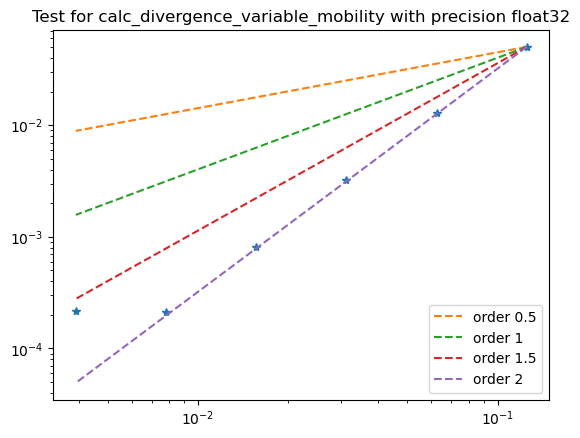

In [5]:
sol_type_2 = 1
precision = np.float32
dx, errors = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.PeriodicCahnHilliardSolver(vf,f,device=device),
              test_function  = lambda s: s.calc_divergence_variable_mobility(
                                s.apply_periodic_BC_cell_center(init_mu := torch.from_numpy(np.pad(init_fun_mu(*s.data.grid), 1)).unsqueeze(0)),
                                s.apply_periodic_BC_cell_center(s.field)
                               ),
              init_fun       = init_fun_c,
              exact_fun      = result_fun,
              convention     = 'cell_center',
              dtype          = precision,
              powers = np.array([3,4,5,6,7,8])
             )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for calc_divergence_variable_mobility with precision {precision.__name__}')
plt.show()


### Test 3: Compute div( c*(1-c)*grad(mu) ) with numerically computed mu from c

This test shows that for fourth order spatial gradients based on a finite difference scheme, single precision is not sufficient for small dx.

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors:       [0.09942681 0.02579302 0.00650897 0.00163107 0.00040801 0.00010202]
Convergence rate from slope fit: 1.9881920019513877


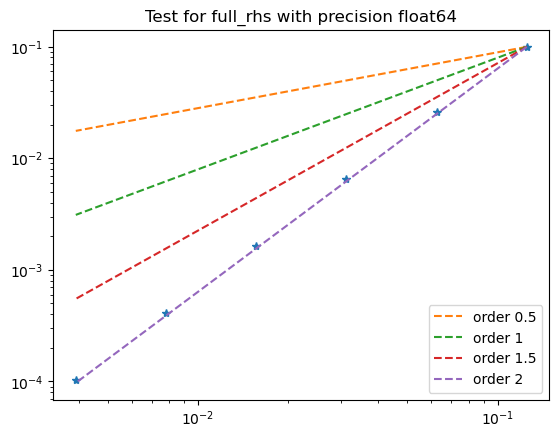

In [6]:
alpha = 0.4
beta = 0.1

def init_fun_c(x,y,z):
    fun = alpha + beta*sin(2*pi*x)
    return fun

def result_fun(x,y,z):
    fun = pi**2*beta*(-2*beta*(alpha + beta*sin(2*pi*x))*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 - 2*beta*(alpha + beta*sin(2*pi*x) - 1)*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 + (alpha + beta*sin(2*pi*x))*(alpha + beta*sin(2*pi*x) - 1)*(144.0*alpha**2*sin(2*pi*x) - 576.0*alpha*beta*(1 - cos(2*pi*x))**2 - 1152.0*alpha*beta*cos(2*pi*x) + 864.0*alpha*beta - 144.0*alpha*sin(2*pi*x) - 432.0*beta**2*(1 - cos(2*pi*x))**2*sin(2*pi*x) + 576.0*beta**2*sin(2*pi*x) - 432.0*beta**2*sin(4*pi*x) + 288.0*beta*(1 - cos(2*pi*x))**2 + 576.0*beta*cos(2*pi*x) - 432.0*beta + 24.0*sin(2*pi*x) + 96.0*pi**2*sin(2*pi*x)))
    return fun

precision = np.float64 #32
dx, errors = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.PeriodicCahnHilliardSolver(vf,f,device=device),
              test_function  = lambda s: s.calc_divergence_variable_mobility(
                                s.apply_periodic_BC_cell_center(
                                  (mu:= 18/s.eps*s.field*(1-s.field)*(1-2*s.field) 
                                   -2*s.eps*s.calc_laplace(s.apply_periodic_BC_cell_center(s.field)))), \
                                s.apply_periodic_BC_cell_center(s.field)
                                ),
              init_fun       = init_fun_c,
              exact_fun      = result_fun,
              convention     = 'cell_center',
              dtype          = precision,
              powers = np.array([3,4,5,6,7,8])
             )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision.__name__}')
plt.show()


### Test 4: Laplacian on field with ZERO Dirichlet BCs in x direction

There are two ways to enforce Dirichlet boundary conditions depending on the grid convention.
1. Cell centered grid: Works with ghost nodes and the value of c outside the domain is set accordingly. Commonly, ``c = 2*c_BC - c[0]`` is used
2. In a staggered grid configuration, the nodes at which the concentration values are stored, actually lie on the domain boundary and can be set to the corresponding given boundary value

In [7]:
import torch.nn.functional as F

def calc_laplace_corr(self, padded):
    laplace = (padded[:, 1:-1, 2:, 1:-1] + padded[:, 1:-1, :-2, 1:-1]) * self.div_dx2[1] + \
              (padded[:, 1:-1, 1:-1, 2:] + padded[:, 1:-1, 1:-1, :-2]) * self.div_dx2[2] - \
              2 * padded[:, 1:-1, 1:-1, 1:-1] * (self.div_dx2[1]+self.div_dx2[2])
    laplace[:,1:-1,:,:] += (padded[:, 3:-1, 1:-1, 1:-1] - 2*padded[:, 2:-2, 1:-1, 1:-1] + padded[:, 1:-3, 1:-1, 1:-1]) * self.div_dx2[0]
    laplace[:,0,:,:]  += (padded[:, 2, 1:-1, 1:-1] - 3*padded[:, 1, 1:-1, 1:-1] + 2*0) * self.div_dx2[0] *4/3
    laplace[:,-1,:,:] += (padded[:,-3, 1:-1, 1:-1] - 3*padded[:,-2, 1:-1, 1:-1] + 2*0) * self.div_dx2[0] *4/3
    return laplace

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing 2: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing 3: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors: [0.27566833 0.19684233 0.13959939 0.09879247 0.06987192 0.04940966]
Convergence rate from slope fit: 0.4966265599747126


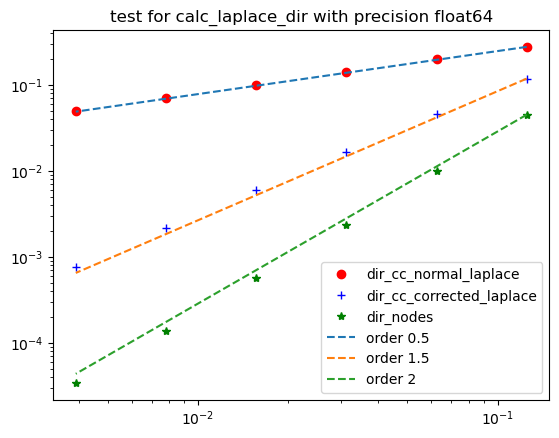

In [8]:
def init_fun(x,y,z):
    # return sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z) * ( 2**2 + 4**2 + 6**2)**(-1) *pi**(-2)
    return (x*(1-x))**2

def laplace_init_fun(x,y,z):
    # return -sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z)
    return 2 - 12*x + 12*x**2
        
precision = np.float64 #32
powers = np.array([3,4,5,6,7,8])
# Use standard laplace and cell centered grid
dx1, errors1 = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.MixedCahnHilliardSolver(vf, f, device=device),
              test_function  = lambda s: s.calc_laplace(s.apply_dirichlet_periodic_BC_cell_center(s.field))[:,1:-1,1:-1,1:-1],
              init_fun       = init_fun,
              exact_fun      = laplace_init_fun,
              convention     = 'cell_center',
              dtype          = precision,
              powers = powers
             )
# Use corrected laplace and cell centered grid
dx2, errors2 = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.MixedCahnHilliardSolver(vf, f, device=device),
              test_function  = lambda s: calc_laplace_corr(s, s.apply_dirichlet_periodic_BC_cell_center(s.field)),
              init_fun       = init_fun,
              exact_fun      = laplace_init_fun,
              convention     = 'cell_center',
              dtype          = precision,
              powers = np.array([3,4,5,6,7,8])
             )
# Use staggered grid with boundary nodes
dx3, errors3 = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.MixedCahnHilliardSolver(vf, f, device=device),
              test_function  = lambda s: s.calc_laplace(s.apply_dirichlet_periodic_BC_staggered_x(s.field))[:,1:-1,1:-1,1:-1],
              init_fun       = init_fun,
              exact_fun      = laplace_init_fun,
              convention     = 'staggered_x',
              dtype          = precision,
              powers = powers
             )

print(f"Grid spacing: {dx1}")
print(f"Grid spacing 2: {dx2}")
print(f"Grid spacing 3: {dx3}")
print(f"Errors: {errors1}")
slope, _ = np.polyfit(np.log(dx1), np.log(errors1), 1)
print("Convergence rate from slope fit:", slope) 

plt.loglog(dx1, errors1, 'o', color='red', label='dir_cc_normal_laplace')
plt.loglog(dx2, errors2, '+', color='blue', label='dir_cc_corrected_laplace')
plt.loglog(dx3, errors3, '*', color='green', label='dir_nodes')
plt.loglog(dx1, errors1[0]/dx1[0]**0.5*dx1**0.5, '--', label='order 0.5')
plt.loglog(dx2, errors2[0]/dx2[0]**1.5*dx2**1.5, '--', label='order 1.5')
plt.loglog(dx3, errors3[0]/dx3[0]**2*dx3**2, '--', label='order 2')
plt.legend()
plt.title(f'test for calc_laplace_dir with precision {precision.__name__}')
plt.show()

The big take-away: Enforcing Dirichlet boundary conditions on a cell centered grid does not maintain the 2nd order convergence! In this case, the staggered grid configuration performs much better.

### Test 5: Laplacian with NON-ZERO Dirichlet BCs in x-direction

In [9]:
def init_fun(x,y,z):
    if sol_type == 1: 
        bc_l, bc_r = (1, 1)
        fun = 1.0 + sin(pi*x)
    if sol_type == 2: 
        bc_l, bc_r = (1, -1)
        fun =  cos(pi*x)**3
    if sol_type == 3:
        b = 0.0
        bc_l, bc_r = (b, b)
        fun =  b +  x*(1-x)
    if sol_type == 4: 
        b = 0.0
        bc_l, bc_r = (b, b)
        fun =  b +  ( x*(1-x) )**2
    if sol_type == 5: 
        b = 0.0
        bc_l, bc_r = (b, b)
        fun =  b +  ( x*(1-x) )**3
    # return bc_l, bc_r, fun
    return fun

def laplace_init_fun(x,y,z):
    if sol_type == 1:
        return sin(pi*x) *pi**(2) * (-1)
    if sol_type == 2: 
        return  3*pi**2*(2*sin(pi*x)**2 - cos(pi*x)**2)*cos(pi*x)
    if sol_type == 3: 
        return -2.0 + 0.0*x
    if sol_type == 4: 
        return 2*(x**2 + 4*x*(x - 1) + (x - 1)**2)
    if sol_type == 5: 
        return -6*x*(x - 1)*(x**2 + 3*x*(x - 1) + (x - 1)**2)

sol_type = 2
Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors:       [0.29488264 0.17232316 0.11430546 0.07948943 0.05597689 0.03954163]
Errors:       [1.15710199e-01 2.82262661e-02 6.96648953e-03 1.72914485e-03
 4.30630140e-04 1.07444009e-04]
Convergence rate from slope fit: 0.5681194999592555


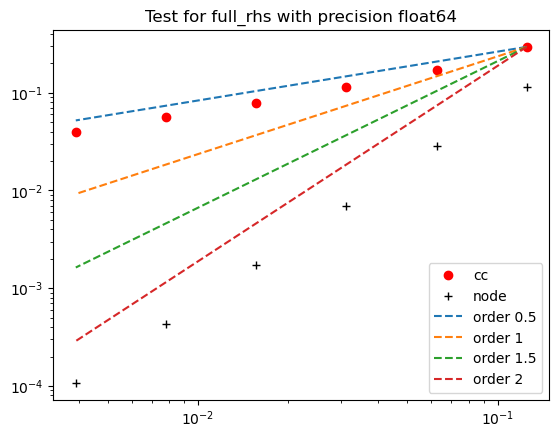

In [10]:
sol_type = 2
print(f'sol_type = {sol_type}')

precision = np.float64 #32
bc_l, bc_r = (0.7, 0.7)
bc_l, bc_r = (1, 1)
bc_l, bc_r = (1, -1)
# bc_l, bc_r = (0, 0)

dx, errors = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.MixedCahnHilliardSolver(vf, f, device=device),
              test_function  = lambda s: s.calc_laplace(s.apply_dirichlet_periodic_BC_cell_center(s.field, bc0=bc_l, bc1=bc_r))[:,1:-1,1:-1,1:-1],
              convention     = 'cell_center',
              init_fun       = init_fun,
              exact_fun      = laplace_init_fun,
              dtype          = precision,
              powers = np.array([3,4,5,6,7,8])
             )
dx2, errors2 = run_convergence_test(
              solver_call    = lambda vf, f, device='cpu': 
                                vox.MixedCahnHilliardSolver(vf, f, device=device),
              test_function  = lambda s: s.calc_laplace(s.apply_dirichlet_periodic_BC_staggered_x(s.field, bc0=bc_l, bc1=bc_r))[:,1:-1,1:-1,1:-1],
              convention     = 'staggered_x',
              init_fun       = init_fun,
              exact_fun      = laplace_init_fun,
              dtype          = precision,
              powers = np.array([3,4,5,6,7,8])
             )

print(f"Grid spacing: {dx}")
print(f"Grid spacing: {dx2}")
print(f"Errors:       {errors}")
print(f"Errors:       {errors2}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors, 'o', label='cc', color='red')
plt.loglog(dx2, errors2, '+', label='node', color='black')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision.__name__}')
plt.show()